# 地方競馬（NAR）クラス推移（昇級・降級）導入モデル (10モデル)

09モデルの最適化パラメータを継承し、さらに「クラス推移（昇級・降級）」を特徴量として導入します。
地方競馬において、降級馬（相手が楽になる馬）の地力は非常に強力なシグナルとなります。

### 導入される特徴量
- **クラスランク (`class_rank`)**: レースの格付け（A1=10, B1=8, C1=5, 2歳=1 など）。
- **クラス差 (`class_diff`)**: 前走から今回のレースでどれだけ格付けが変わったか。
- **降級フラグ (`is_demoted`)**: 前走よりクラスが下がった場合に 1。
- **昇級フラグ (`is_promoted`)**: 前走よりクラスが上がった場合に 1。

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
import lightgbm as lgb
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error

# プロジェクトのsrcディレクトリをパスに追加
src_path = os.path.abspath(os.path.join(os.getcwd(), '../../src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from nar.loader import NarDataLoader
from nar.features import NarFeatureGenerator

%matplotlib inline
sns.set(font="IPAexGothic", style="whitegrid")

/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py:18: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


## 1. データのロードと特徴量生成

高度な特徴量（休養期間、馬体重増減、人馬相性など）を含めて生成します。

In [2]:
loader = NarDataLoader()
# データのロード（学習用に十分な量を取得）
raw_df = loader.load(limit=150000, region='south_kanto')

# 特徴量生成（高度特徴量機能を含む）
generator = NarFeatureGenerator(history_windows=[1, 2, 3, 4, 5])
df = generator.generate_features(raw_df)

# ラベル（着順）が存在するデータのみに絞り込み
df = df.dropna(subset=['rank']).copy()
df['date'] = pd.to_datetime(df['date'])

print(f"データ件数: {len(df)}")

重複データを削除しました: 150000 -> 143895 件


データ件数: 37346


## 2. 特徴量の整理と時系列分割

使用する特徴量を定義し、カテゴリ変数の処理を行います。

In [3]:
# 特徴量リストの定義
baseline_features = [
    'distance', 'venue', 'state', 'frame_number', 'horse_number', 'weight', 'impost',
    'jockey_win_rate', 'jockey_place_rate', 'trainer_win_rate', 'trainer_place_rate',
    'horse_run_count'
] + [col for col in df.columns if 'horse_prev' in col]

advanced_features = [
    'gender', 'age', 'days_since_prev_race', 'weight_diff',
    'horse_jockey_place_rate', 'is_consecutive_jockey',
    'distance_diff', 'horse_venue_place_rate',
    'trainer_30d_win_rate',
    'impost_diff', 'was_accident_prev1', 'weighted_si_momentum', 'weighted_rank_momentum',
    'class_rank', 'class_diff', 'is_promoted', 'is_demoted'
]

features = list(set(baseline_features + advanced_features))

# カテゴリ変数の処理
categorical_cols = ['venue', 'state', 'gender']
for col in features:
    if col in categorical_cols:
        df[col] = df[col].astype(str).astype('category')
    else:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 時系列分割（直近約20%をテストデータに）
split_date = df['date'].quantile(0.8)
train_df = df[df['date'] < split_date].copy()
test_df = df[df['date'] >= split_date].copy()

print(f"訓練データ: {len(train_df)} ({train_df['date'].min().date()} ~ {train_df['date'].max().date()})")
print(f"テストデータ: {len(test_df)} ({test_df['date'].min().date()} ~ {test_df['date'].max().date()})")

訓練データ: 29819 (2014-01-01 ~ 2014-10-27)
テストデータ: 7527 (2014-10-28 ~ 2015-01-07)


## 3. モデル学習

LightGBM Regressorを用いて期待着順を予測します。

In [4]:
model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.0796,
    num_leaves=148,
    max_depth=6,
    feature_fraction=0.56,
    bagging_fraction=0.79,
    bagging_freq=1,
    min_child_samples=5,
    random_state=42,
    importance_type='gain'
)

## 4. 精度評価

相関係数と的中率を算出し、ベースラインからの改善を確認します。

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] bagging_fraction is set=0.79, subsample=1.0 will be ignored. Current value: bagging_fraction=0.79
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] bagging_fraction is set=0.79, subsample=1.0 will be ignored. Current value: bagging_fraction=0.79
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5836
[LightGBM] [Info] Number of data points in the train set: 29819, number of used features: 49
[Ligh

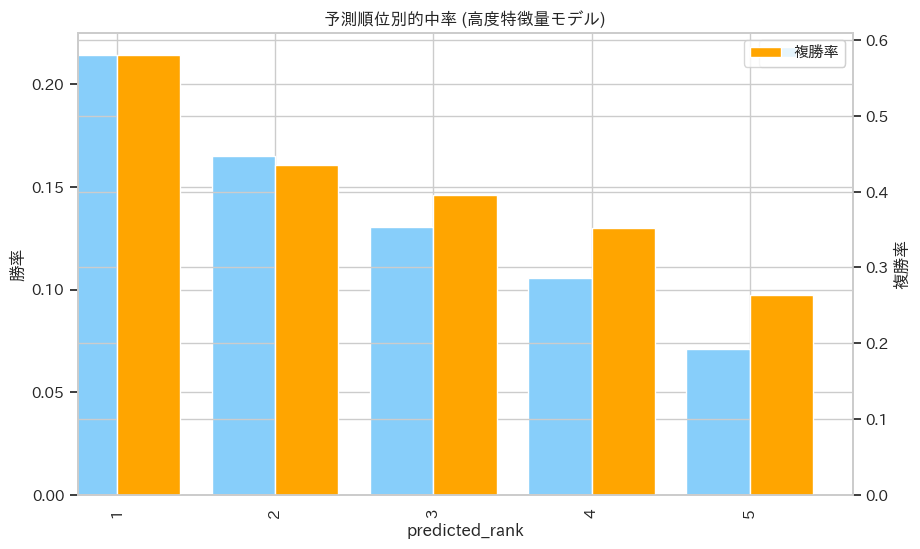

In [5]:
model.fit(train_df[features], train_df['rank'])
test_df['pred_score'] = model.predict(test_df[features])

# 1. Spearman相関
correlation, _ = spearmanr(test_df['pred_score'], test_df['rank'])
print(f"Spearman順位相関係数: {correlation:.4f}")

# 2. 的中率の算出
test_df['pred_rank'] = test_df.groupby('race_id')['pred_score'].rank(method='min', ascending=True)

eval_list = []
for r in range(1, 6):
    matches = test_df[test_df['pred_rank'] == r]
    win_rate = (matches['rank'] == 1).mean()
    place_rate = (matches['rank'] <= 3).mean()
    eval_list.append({'predicted_rank': r, 'win_rate': win_rate, 'place_rate': place_rate})

eval_df = pd.DataFrame(eval_list)
print("\n予測順位別 的中率:")
print(eval_df)

# 可視化
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
eval_df.plot(x='predicted_rank', y='win_rate', kind='bar', ax=ax1, color='lightskyblue', position=1, width=0.4, label='勝率')
eval_df.plot(x='predicted_rank', y='place_rate', kind='bar', ax=ax2, color='orange', position=0, width=0.4, label='複勝率')
ax1.set_ylabel('勝率')
ax2.set_ylabel('複勝率')
ax1.set_title('予測順位別的中率 (高度特徴量モデル)')
plt.show()

## 5. 特徴量重要度

新しく追加した特徴量がどのように寄与したかを確認します。

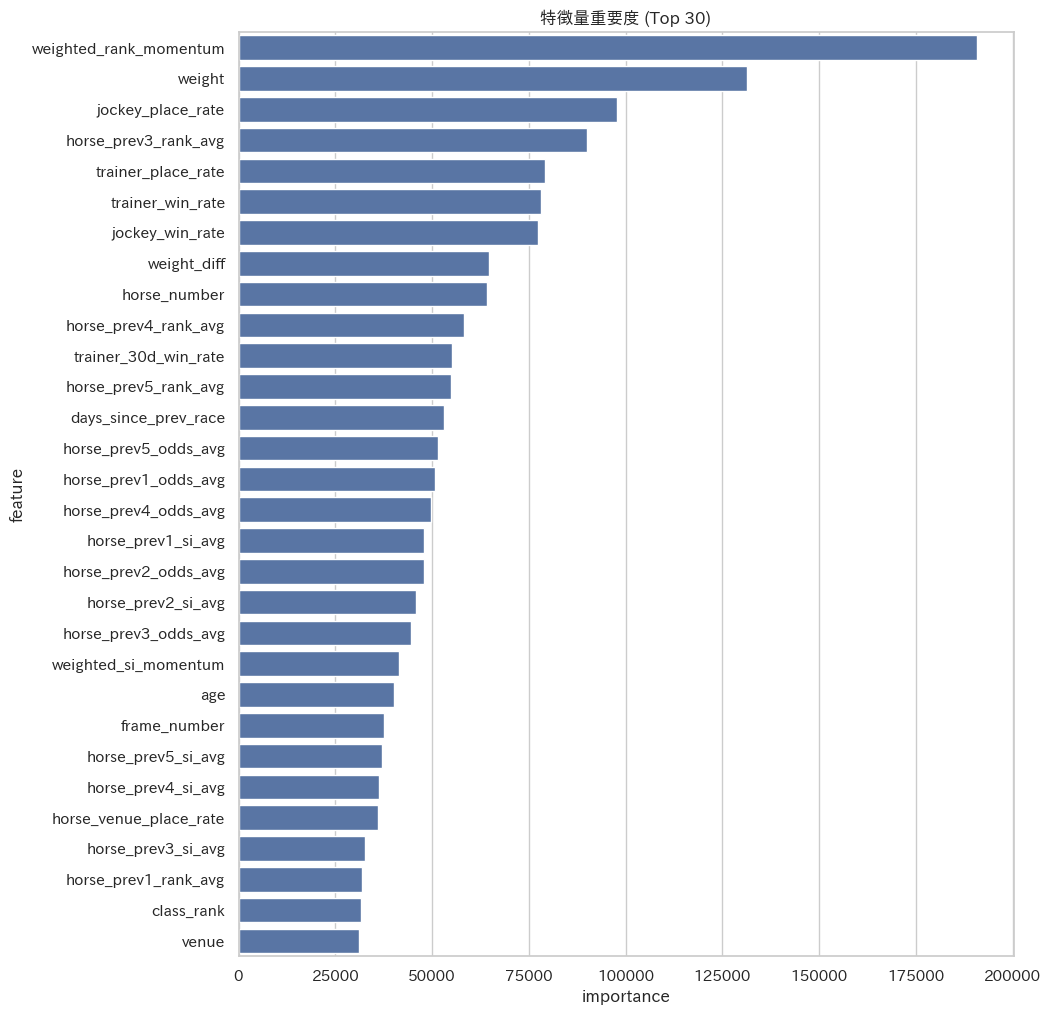

In [6]:
importances = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='importance', y='feature', data=importances.head(30))
plt.title('特徴量重要度 (Top 30)')
plt.show()